In [175]:
import cv2
import IPython
import matplotlib.pyplot as pyplot
import keras
import keras.utils

ERROR! Session/line number was not unique in database. History logging moved to new session 6


In [130]:
image = cv2.imread('E:/Work/NonoGram/Data/sample.png') 
#image = cv2.imread('E:/Work/NonoGram/Data/puzzle.jpg') 


In [131]:
imageCopy = image.copy()
imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)
(_, imageCopy) = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)

#blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#edges = cv2.Canny(blurred, 50, 150)
#imageCopy = cv2.Canny(imageCopy, 50, 150)
contours, _ = cv2.findContours(255-imageCopy.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


19260.0
[[[ 17  56]]

 [[ 17 158]]

 [[163 158]]

 [[163  14]]

 [[ 60  14]]

 [[ 58  56]]]
19223.0
[[[ 60  14]]

 [[ 60  54]]

 [[ 58  56]]

 [[ 17  56]]

 [[ 17 158]]

 [[ 59 158]]

 [[ 60 159]]

 [[ 62 159]]

 [[ 63 158]]

 [[163 158]]

 [[163  14]]]


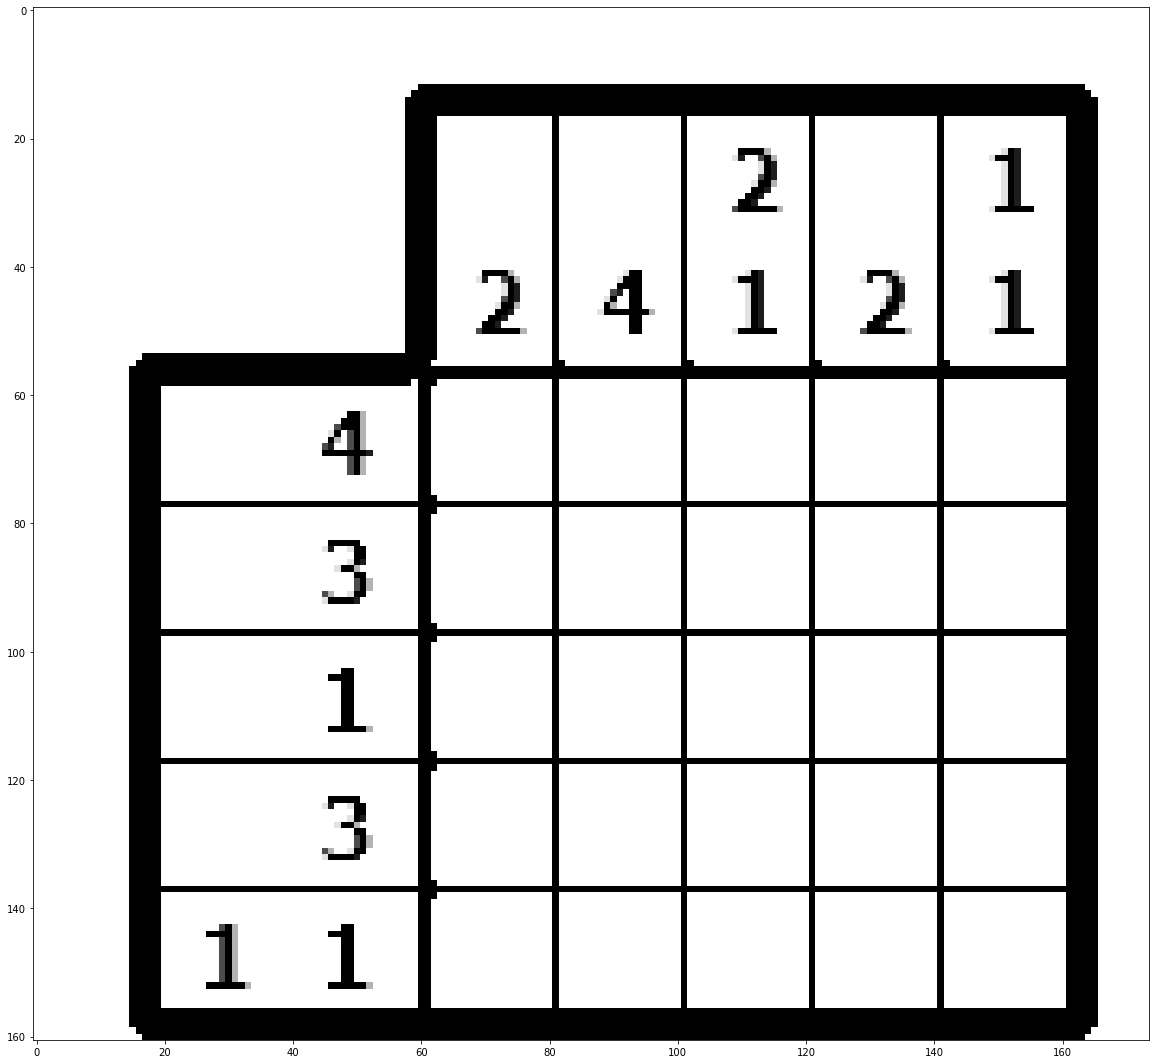

In [132]:
newContours = []
for contour in contours:
    if len(contour) > 0:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        print(cv2.contourArea(approx))
        print(approx)        
        print(cv2.contourArea(contour))
        print(contour)
        newContours.append(approx)
imageContours = imageCopy.copy()
cv2.drawContours(imageContours, contours, -1, (0, 255, 0), 3)        
pyplot.figure(figsize= (20,20))
pyplot.imshow(imageContours, cmap="gray")
pyplot.show()


In [135]:
outline = newContours[0]

[58 56]


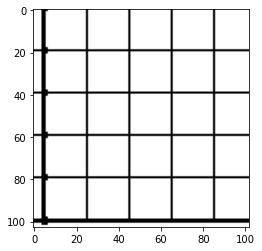

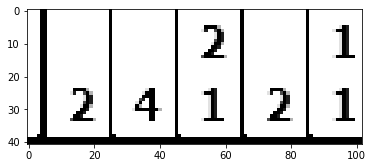

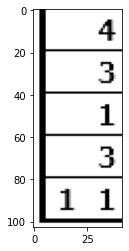

In [171]:
topLeft = (outline.min(axis=0, keepdims=True))[0][0]
bottomRight = outline.max(axis=0, keepdims=True)[0][0]
for pointArray in outline:
    point = pointArray[0]
    if (
            point[0] > topLeft[0] and point[0] < bottomRight[0] and
            point[1] > topLeft[1] and point[1] < bottomRight[1]
        ):
        insidePoint = point
print(insidePoint)
insideImage = imageCopy[insidePoint[0]:bottomRight[0], insidePoint[1]:bottomRight[1]]
topSide = imageCopy[topLeft[0]:insidePoint[0], insidePoint[1]:bottomRight[1]]
leftSide = imageCopy[insidePoint[0]:bottomRight[0], topLeft[1]:insidePoint[1]]

pyplot.imshow(insideImage, cmap="gray")
pyplot.show()
pyplot.imshow(topSide, cmap="gray")
pyplot.show()
pyplot.imshow(leftSide, cmap="gray")
pyplot.show()

# todo check and test :D


In [142]:
print()

[[[17 14]]]


In [ ]:
import numpy as np
from keras.utils import np_utils
# Load the MNIST dataset from OpenCV (this loads pre-trained data)
# This is a convenient way to quickly get started with digit recognition.
def createDigitRecognizer():
    # Load the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
    
    # Preprocess the images
    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255

    # Reshape the images and add a channel dimension
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    # One-hot encode the labels
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    
    # Build the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    # Train the model
    #model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))
    #return model
digitRecognizer = createDigitRecognizer()

ERROR! Session/line number was not unique in database. History logging moved to new session 7


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jaspe\anaconda3\envs\tensorflowGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-176-fac9dbebf2a6>", line 40, in <module>
    digitRecognizer = createDigitRecognizer()
  File "<ipython-input-176-fac9dbebf2a6>", line 18, in createDigitRecognizer
    train_labels = to_categorical(train_labels)
NameError: name 'to_categorical' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\jaspe\anaconda3\envs\tensorflowGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\jaspe\anaconda3\envs\tensorflo

In [ ]:

# Define a function to process the image and recognize digits
def recognize_digit(image):
    # Preprocess the image (resize, grayscale, thresholding, etc.)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the digit in the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Get bounding box around the contour (digit)
        x, y, w, h = cv2.boundingRect(contour)
        digit_image = thresh[y:y+h, x:x+w]

        # Resize the digit image to match the trained model size (28x28 for MNIST)
        digit_image_resized = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)
        
        # Flatten the image to a 1D array (as the model expects this format)
        digit_image_flattened = digit_image_resized.flatten().reshape(1, -1).astype(np.float32)

        # Use KNN to predict the digit
        _, result, _, _ = mnist.findNearest(digit_image_flattened, k=3)

        # Get the predicted digit
        predicted_digit = int(result[0][0])
        print(f"Predicted digit: {predicted_digit}")
        return predicted_digit

# Load an image of a handwritten digit (replace with your own image)
#image = cv2.imread('digit_image.png')  # Replace with the actual image path
recognized_digit = recognize_digit(imageCopy)

# Show the original image
cv2.imshow("Input Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()